# Chapter 8. Conditional Manatees

In [2]:
import math
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

from src import utils

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Code 8.1

In [17]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].apply(math.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609,0.879712,0.138342
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929,0.964755,0.552564
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263,1.166270,0.123992
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032,1.104485,0.124960
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343,0.914904,0.433409


### Code 8.2

In [40]:
def model(rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + b * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m8_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_1,
    optim.Adam(0.1),
    Trace_ELBO(),
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
p8_1, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2392.32it/s, init loss: 810.4496, avg. loss [951-1000]: -93.2910]


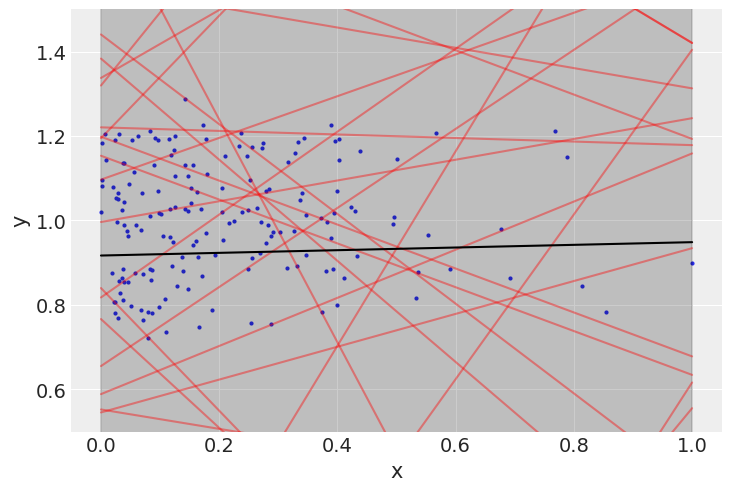

In [46]:
utils.plot_prior_predictive(
    m8_1, values=jnp.arange(0, 1.01, 0.01), x_true=dd["rugged_std"], y_true=dd["log_gdp_std"].values,
    n_random_lines=50, ylim=(0.5, 1.5)
)

### Code 8.3

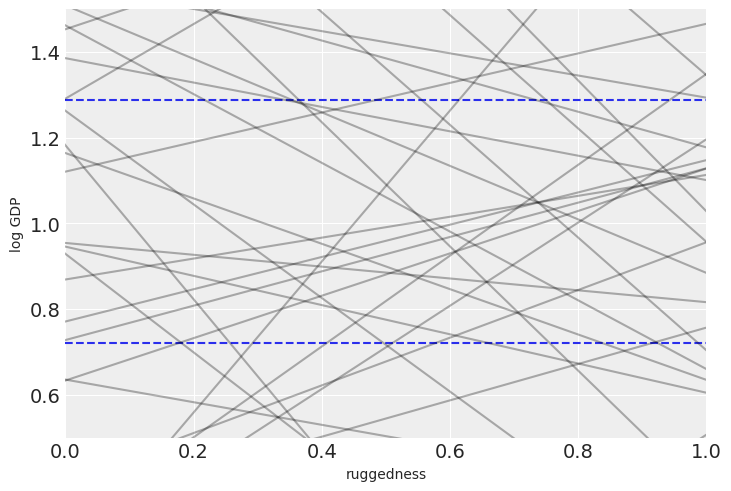

In [18]:
predictive = Predictive(m8_1.model, num_samples=1000, return_sites=["a", "b", "sigma"])
prior = predictive(random.PRNGKey(7), rugged_std=0)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5), xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = jnp.linspace(-0.1, 1.1, num=30)
mu = Predictive(m8_1.model, prior, return_sites=["mu"])(
    random.PRNGKey(7), rugged_std=rugged_seq
)["mu"]
for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

### Code 8.4

### Code 8.5

In [48]:
def model(rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1))
    b = numpyro.sample("b", dist.Normal(0, 0.3))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + b * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m8_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_1,
    optim.Adam(0.1),
    Trace_ELBO(),
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
p8_1, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2661.62it/s, init loss: 852.5240, avg. loss [951-1000]: -96.7974]


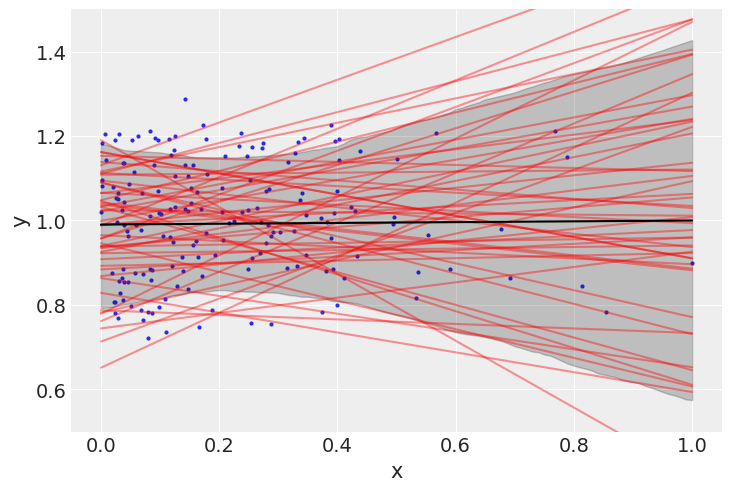

In [49]:
utils.plot_prior_predictive(
    m8_1, values=jnp.arange(0, 1.01, 0.01), x_true=dd["rugged_std"], y_true=dd["log_gdp_std"].values,
    n_random_lines=50, ylim=(0.5, 1.5)
)

### Code 8.6

In [50]:
post = m8_1.sample_posterior(random.PRNGKey(1), p8_1, (1000,))
print_summary({k: v for k, v in post.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.00      0.01      1.00      0.98      1.02    931.50      1.00
         b      0.00      0.06      0.00     -0.08      0.10   1111.62      1.00
     sigma      0.14      0.01      0.14      0.13      0.15    949.29      1.00



### Code 8.7

In [51]:
# make variable to index Africa (0) or not (1)
dd["cid"] = jnp.where(dd.cont_africa.values == 1, 0, 1)

### Code 8.8

In [53]:
def model(cid, rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a[cid] + b * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m8_2 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_2,
    optim.Adam(0.1),
    Trace_ELBO(),
    cid=dd.cid.values,
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
p8_2, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2408.92it/s, init loss: 1785.1527, avg. loss [951-1000]: -130.2140]


### Code 8.9

In [54]:
post = m8_1.sample_posterior(random.PRNGKey(2), p8_1, (1000,))
logprob = log_likelihood(
    m8_1.model, post, rugged_std=dd.rugged_std.values, log_gdp_std=dd.log_gdp_std.values
)
az8_1 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})
post = m8_2.sample_posterior(random.PRNGKey(2), p8_2, (1000,))
logprob = log_likelihood(
    m8_2.model,
    post,
    rugged_std=dd.rugged_std.values,
    cid=dd.cid.values,
    log_gdp_std=dd.log_gdp_std.values,
)
az8_2 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})
az.compare({"m8.1": az8_1, "m8.2": az8_2}, ic="waic", scale="deviance")

See http://arxiv.org/abs/1507.04544 for details


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.2,0,-252.359564,4.153816,0.00000,0.96367,15.091011,0.000000,True,deviance
m8.1,1,-188.817815,2.653286,63.54175,0.03633,13.245194,14.957733,False,deviance


### Code 8.10

In [55]:
post = m8_2.sample_posterior(random.PRNGKey(1), p8_2, (1000,))
print_summary({k: v for k, v in post.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.88      0.02      0.88      0.86      0.90   1049.96      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07    824.00      1.00
         b     -0.05      0.05     -0.05     -0.13      0.02    999.08      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    961.34      1.00



### Code 8.11

In [58]:
post = m8_2.sample_posterior(random.PRNGKey(1), p8_2, (1000,))
diff_a1_a2 = post["a"][:, 0] - post["a"][:, 1]
jnp.percentile(diff_a1_a2, q=jnp.array((5.5, 94.5)))

Array([-0.19980265, -0.13965617], dtype=float32)

### Code 8.12

In [60]:
rugged_seq = jnp.linspace(start=-1, stop=1.1, num=30)

# compute mu over samples, fixing cid=1
predictive = Predictive(m8_2.model, post, return_sites=["mu"])
mu_NotAfrica = predictive(random.PRNGKey(2), cid=1, rugged_std=rugged_seq)["mu"]

# compute mu over samples, fixing cid=0
mu_Africa = predictive(random.PRNGKey(2), cid=0, rugged_std=rugged_seq)["mu"]

# summarize to means and intervals
mu_NotAfrica_mu = jnp.mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = jnp.percentile(mu_NotAfrica, q=jnp.array((1.5, 98.5)), axis=0)
mu_Africa_mu = jnp.mean(mu_Africa, 0)
mu_Africa_ci = jnp.percentile(mu_Africa, q=jnp.array((1.5, 98.5)), axis=0)

### Code 8.13

In [61]:
def model(cid, rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a[cid] + b[cid] * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m8_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_3,
    optim.Adam(0.1),
    Trace_ELBO(),
    cid=dd.cid.values,
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
p8_3, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2299.48it/s, init loss: 1670.7776, avg. loss [951-1000]: -134.7926]


### Code 8.14

In [62]:
post = m8_3.sample_posterior(random.PRNGKey(1), p8_3, (1000,))
print_summary({k: v for k, v in post.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   1009.20      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07    755.33      1.00
      b[0]      0.13      0.07      0.13      0.01      0.24   1045.06      1.00
      b[1]     -0.15      0.06     -0.14     -0.23     -0.05   1003.36      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    810.01      1.00



### Code 8.15

In [63]:
post = m8_1.sample_posterior(random.PRNGKey(2), p8_1, (1000,))
logprob = log_likelihood(
    m8_1.model, post, rugged_std=dd.rugged_std.values, log_gdp_std=dd.log_gdp_std.values
)
az8_1 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})
post = m8_2.sample_posterior(random.PRNGKey(2), p8_2, (1000,))
logprob = log_likelihood(
    m8_2.model,
    post,
    rugged_std=dd.rugged_std.values,
    cid=dd.cid.values,
    log_gdp_std=dd.log_gdp_std.values,
)
az8_3 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})
post = m8_3.sample_posterior(random.PRNGKey(2), p8_3, (1000,))
logprob = log_likelihood(
    m8_3.model,
    post,
    rugged_std=dd.rugged_std.values,
    cid=dd.cid.values,
    log_gdp_std=dd.log_gdp_std.values,
)
az8_3 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})
az.compare({"m8.1": az8_1, "m8.2": az8_2, "m8.3": az8_3}, ic="waic", scale="deviance")

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.3,0,-259.176065,5.103495,0.00000,0.836852,15.039592,0.000000,True,deviance
m8.2,1,-252.359564,4.153816,6.81650,0.163148,15.091011,6.675916,True,deviance
m8.1,2,-188.817815,2.653286,70.35825,0.000000,13.245194,15.342726,False,deviance


### Code 8.16

In [64]:
waic_list = az.waic(az8_3, pointwise=True, scale="deviance").waic_i.values

See http://arxiv.org/abs/1507.04544 for details


### Code 8.17

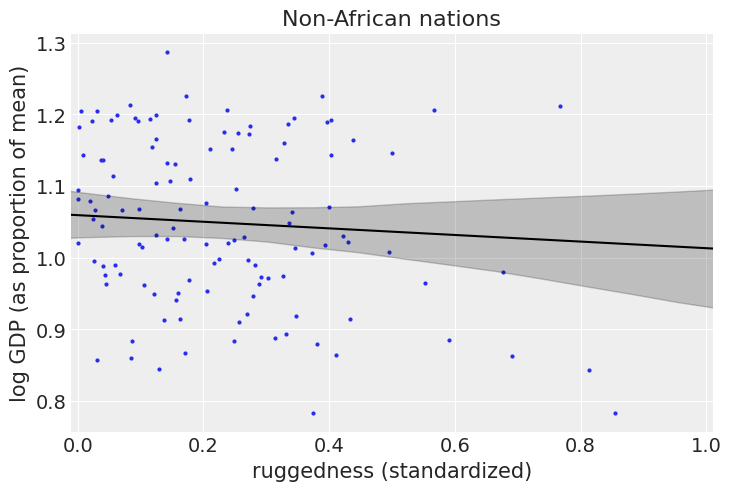

In [66]:
# plot non-Africa - cid=1
d_A0 = dd[dd["cid"] == 1]
az.plot_pair(d_A0[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(
    xlim=(-0.01, 1.01),
    xlabel="ruggedness (standardized)",
    ylabel="log GDP (as proportion of mean)",
)
mu = predictive(random.PRNGKey(2), cid=1, rugged_std=rugged_seq)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_ci = jnp.percentile(mu, q=jnp.array((1.5, 98.5)), axis=0)
plt.plot(rugged_seq, mu_mean, "k")
plt.fill_between(rugged_seq, mu_ci[0], mu_ci[1], color="k", alpha=0.2)
plt.title("Non-African nations")
plt.show()

### Code 8.18

In [67]:
rugged_seq = jnp.linspace(start=-0.2, stop=1.2, num=30)
post = m8_3.sample_posterior(random.PRNGKey(1), p8_3, (1000,))
predictive = Predictive(m8_3.model, post, return_sites=["mu"])
muA = predictive(random.PRNGKey(2), cid=0, rugged_std=rugged_seq)["mu"]
muN = predictive(random.PRNGKey(2), cid=1, rugged_std=rugged_seq)["mu"]
delta = muA - muN

### Code 8.19

In [68]:
tulips = pd.read_csv("../data/tulips.csv", sep=";")
d = tulips
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


### Code 8.20

In [69]:
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

### Code 8.21

In [70]:
a = dist.Normal(0.5, 1).sample(random.PRNGKey(0), (int(1e4),))
jnp.sum((a < 0) | (a > 1)) / a.shape[0]

Array(0.6182, dtype=float32)

### Code 8.22

In [71]:
a = dist.Normal(0.5, 0.25).sample(random.PRNGKey(0), (int(1e4),))
jnp.sum((a < 0) | (a > 1)) / a.shape[0]

Array(0.0471, dtype=float32)

### Code 8.23

In [73]:
def model(water_cent, shade_cent, blooms_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 0.25))
    bw = numpyro.sample("bw", dist.Normal(0, 0.25))
    bs = numpyro.sample("bs", dist.Normal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bw * water_cent + bs * shade_cent)
    numpyro.sample("blooms_std", dist.Normal(mu, sigma), obs=blooms_std)


m8_4 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_4,
    optim.Adam(1),
    Trace_ELBO(),
    shade_cent=d.shade_cent.values,
    water_cent=d.water_cent.values,
    blooms_std=d.blooms_std.values,
)
p8_4, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2605.02it/s, init loss: 753.9798, avg. loss [951-1000]: -10.2150]


### Code 8.24

In [76]:
def model(water_cent, shade_cent, blooms_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 0.25))
    bw = numpyro.sample("bw", dist.Normal(0, 0.25))
    bs = numpyro.sample("bs", dist.Normal(0, 0.25))
    bws = numpyro.sample("bws", dist.Normal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent
    numpyro.sample("blooms_std", dist.Normal(mu, sigma), obs=blooms_std)


m8_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_5,
    optim.Adam(1),
    Trace_ELBO(),
    shade_cent=d.shade_cent.values,
    water_cent=d.water_cent.values,
    blooms_std=d.blooms_std.values,
)
p8_5, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2342.36it/s, init loss: 133.8938, avg. loss [951-1000]: -16.7087]


### Code 8.25

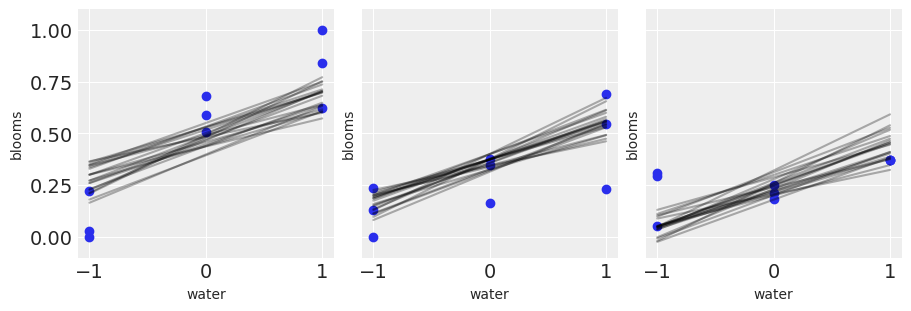

In [77]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")
    post = m8_4.sample_posterior(random.PRNGKey(1), p8_4, (1000,))
    mu = Predictive(m8_4.model, post, return_sites=["mu"])(
        random.PRNGKey(2), shade_cent=s, water_cent=jnp.arange(-1, 2)
    )["mu"]
    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

### Code 8.26

In [27]:
predictive = Predictive(
    m8_5.model, num_samples=1000, return_sites=["a", "bw", "bs", "bws", "sigma"]
)
prior = predictive(random.PRNGKey(7), water_cent=0, shade_cent=0)

### Code 8.27

In [28]:
nettle = pd.read_csv("../data/nettle.csv", sep=";")
d = nettle
d["lang.per.cap"] = d["num.lang"] / d["k.pop"]